In [430]:
import os
import re
import warnings
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt

plt.style.use('Estilo/toutl.mplstyle')
from style import *


In [431]:
df = pd.read_csv('Datos/examen3.csv')

In [432]:
columnas_analizar = df.select_dtypes(include=['int64', 'float64']).drop(columns=['clientnum', 'client_stayed'], errors='ignore').columns.tolist()

def generar_reporte_outliers(df, columnas):
    # Cabecera del reporte
    print("\n" + "="*92)
    print(f"{'REPORTE DE OUTLIERS - ANÁLISIS COMPLETO':^92}")
    print("="*92)
    print(f"{'Columna':<25} {'Tipo':<10} {'Outliers':>10} {'%':>8} {'L. Inferior':>15} {'L. Superior':>15}")
    print("-"*92)
    
    for col in columnas:
        # Cálculo de estadísticas
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lim_inf) | (df[col] > lim_sup)]
        n_outliers = len(outliers)
        pct_outliers = (n_outliers/len(df))*100
        
        # Formateo de números
        str_lim_inf = f"{lim_inf:,.2f}" if isinstance(lim_inf, float) else f"{int(lim_inf):,}"
        str_lim_sup = f"{lim_sup:,.2f}" if isinstance(lim_sup, float) else f"{int(lim_sup):,}"
        
        # Impresión formateada
        print(f"{col:<25} {str(df[col].dtype):<10} {n_outliers:>10,} {pct_outliers:>7.2f}% {str_lim_inf:>15} {str_lim_sup:>15}")
    
    print("="*92)
    print(f"{'Nota: Límites calculados con método IQR (Q1-1.5*IQR, Q3+1.5*IQR)':^92}")
    print("="*92)

# Generar el reporte
generar_reporte_outliers(df, columnas_analizar)


                          REPORTE DE OUTLIERS - ANÁLISIS COMPLETO                           
Columna                   Tipo         Outliers        %     L. Inferior     L. Superior
--------------------------------------------------------------------------------------------
customer_age              int64               2    0.02%           24.50           68.50
dependent_count           int64               0    0.00%           -2.00            6.00
months_on_book            int64             386    3.81%           17.50           53.50
total_relationship_count  int64               0    0.00%            0.00            8.00
months_inactive_12_mon    int64             331    3.27%            0.50            4.50
contacts_count_12_mon     int64             629    6.21%            0.50            4.50
credit_limit              float64           984    9.72%      -10,213.75       23,836.25
total_revolving_bal       int64               0    0.00%       -1,778.50        3,921.50
total_trans_

In [433]:
def generar_reporte_outliers_por_grupo(df, columnas, grupo_col='client_stayed'):
    col_width = 22
    type_width = 10
    outliers_width = 10
    pct_width = 8
    limit_width = 15
    
    for grupo in sorted(df[grupo_col].unique()):
        print(f"\n{'ANÁLISIS PARA CLIENT_STAYED =':<20} {grupo}")
        print("-"*100)
        print(f"{'Columna':<{col_width}} {'Tipo':<{type_width}} {'Outliers':>{outliers_width}} "
              f"{'%':>{pct_width}} {'L. Inferior':>{limit_width}} {'L. Superior':>{limit_width}}")
        print("-"*100)
        
        grupo_df = df[df[grupo_col] == grupo]
        
        for col in columnas:
            # Cálculo de estadísticas para el grupo
            Q1 = grupo_df[col].quantile(0.25)
            Q3 = grupo_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lim_inf = Q1 - 1.5 * IQR
            lim_sup = Q3 + 1.5 * IQR
            
            outliers = grupo_df[(grupo_df[col] < lim_inf) | (grupo_df[col] > lim_sup)]
            n_outliers = len(outliers)
            pct_outliers = (n_outliers/len(grupo_df))*100
            
            # Formateo inteligente de números
            is_float = isinstance(grupo_df[col].iloc[0], float)
            fmt_lim = "{:,.2f}" if is_float else "{:,}"
            
            # Impresión alineada
            print(f"{col:<{col_width}} {str(grupo_df[col].dtype):<{type_width}} "
                  f"{n_outliers:>{outliers_width},} {pct_outliers:>{pct_width-1}.2f}% "
                  f"{fmt_lim.format(lim_inf):>{limit_width}} {fmt_lim.format(lim_sup):>{limit_width}}")
    
    print("="*100)

# Uso de la función
columnas_analizar = df.select_dtypes(include=['int64', 'float64']).drop(columns=['clientnum', 'client_stayed'], errors='ignore').columns.tolist()
generar_reporte_outliers_por_grupo(df, columnas_analizar)


ANÁLISIS PARA CLIENT_STAYED = 0
----------------------------------------------------------------------------------------------------
Columna                Tipo         Outliers        %     L. Inferior     L. Superior
----------------------------------------------------------------------------------------------------
customer_age           int64               0    0.00%            24.5            68.5
dependent_count        int64             199   12.23%             0.5             4.5
months_on_book         int64              77    4.73%            20.0            52.0
total_relationship_count int64               0    0.00%            -2.5             9.5
months_inactive_12_mon int64              66    4.06%             0.5             4.5
contacts_count_12_mon  int64               0    0.00%            -1.0             7.0
credit_limit           float64           173   10.63%       -9,615.25       21,662.75
total_revolving_bal    int64               0    0.00%       -1,955.25      

In [434]:
"""
columna = "customer_age"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para customer_age:", outliers.shape[0])

columna = "months_on_book"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para months_on_book:", outliers.shape[0])

columna = "months_inactive_12_mon"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para months_inactive_12_mon:", outliers.shape[0])

columna = "contacts_count_12_mon"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para contacts_count_12_mon:", outliers.shape[0])

columna = "credit_limit"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para credit_limit:", outliers.shape[0])

columna = "total_trans_amt"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para total_trans_amt:", outliers.shape[0])

columna = "total_trans_ct"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para total_trans_ct:", outliers.shape[0])

df.dtypes
"""

'\ncolumna = "customer_age"\n\nQ1 = df[columna].quantile(0.25)\nQ3 = df[columna].quantile(0.75)\nIQR = Q3 - Q1\n\n\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\n\noutliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]\n\n\nprint("Número de outliers para customer_age:", outliers.shape[0])\n\ncolumna = "months_on_book"\n\nQ1 = df[columna].quantile(0.25)\nQ3 = df[columna].quantile(0.75)\nIQR = Q3 - Q1\n\n\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\n\noutliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]\n\n\nprint("Número de outliers para months_on_book:", outliers.shape[0])\n\ncolumna = "months_inactive_12_mon"\n\nQ1 = df[columna].quantile(0.25)\nQ3 = df[columna].quantile(0.75)\nIQR = Q3 - Q1\n\n\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\n\noutliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]\n\n\nprint("Número de outliers para m

In [ ]:
df['credit_limit'] = df['credit_limit'].astype(int)
columnas_a_tratar = ['months_on_book','total_trans_amt','total_trans_ct','credit_limit']

for valor_stayed in [0, 1]:
    df_grupo = df[df['client_stayed'] == valor_stayed]
    
    for columna in columnas_a_tratar:
        Q1 = df_grupo[columna].quantile(0.25)
        Q3 = df_grupo[columna].quantile(0.75)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - 3 * IQR
        limite_superior = Q3 + 3 * IQR
        
        moda = df_grupo[columna].mode()[0]
        
        mascara = (df['client_stayed'] == valor_stayed) & ((df[columna] < limite_inferior) | (df[columna] > limite_superior))
        df.loc[mascara, columna] = moda




In [437]:

# Verificación

columnas_numericas = ['customer_age', 'months_on_book', 'credit_limit','total_trans_amt','total_trans_ct']

for columna in columnas_numericas:
    # Calcular Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para atípicos
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    
    valor_reemplazo = df[columna].median()  # Mediana es 12.5 en este caso
    df[columna] = np.where(
        df[columna] > limite_superior,
        valor_reemplazo,
    df[columna]
)

print("Valores únicos después de reemplazo:", df[columna].unique())
print("¿Quedan outliers?", any(df[columna] > limite_superior))   


Valores únicos después de reemplazo: [ 42.  33.  20.  28.  24.  31.  36.  32.  26.  17.  29.  27.  21.  30.
  16.  18.  23.  22.  40.  38.  25.  43.  37.  19.  35.  15.  41.  57.
  12.  14.  34.  44.  13.  47.  10.  39.  53.  50.  52.  48.  49.  45.
  11.  55.  46.  54.  60.  51.  63.  58.  59.  61.  78.  64.  65.  62.
  67.  66.  56.  69.  71.  75.  74.  76.  84.  82.  88.  68.  70.  73.
  86.  72.  79.  80.  85.  81.  87.  83.  91.  89.  77. 103.  93.  96.
  99.  92.  90.  94.  95.  98. 100. 102.  97. 101. 104. 105. 106. 107.
 109. 118. 108. 122. 113. 112. 111. 127. 114. 124. 110. 120. 125. 121.
 117. 126. 134. 116. 119. 129. 131. 115. 128. 139. 123. 130. 138. 132.]
¿Quedan outliers? False


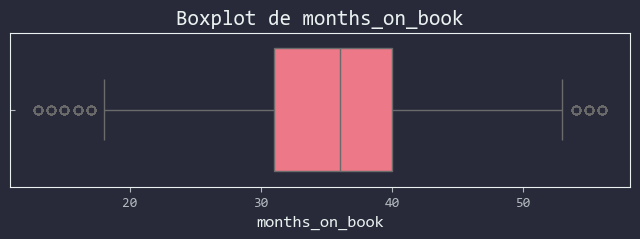

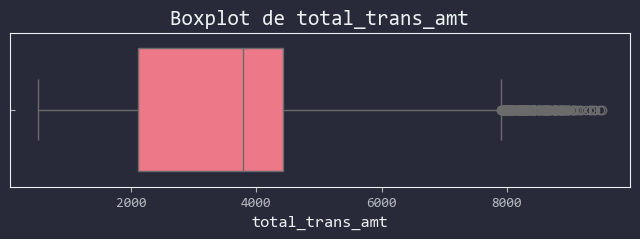

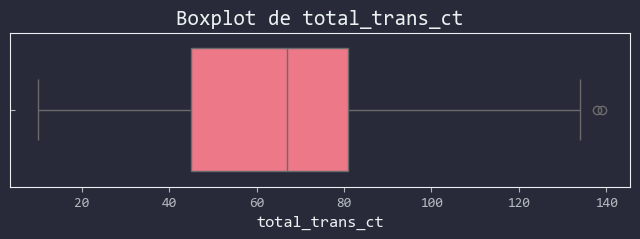

In [438]:
for col in columnas_a_tratar:
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.xlabel(f'{col}')
        plt.show()
    else:
        continue

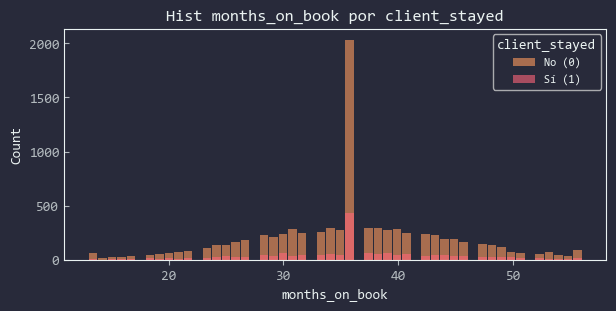

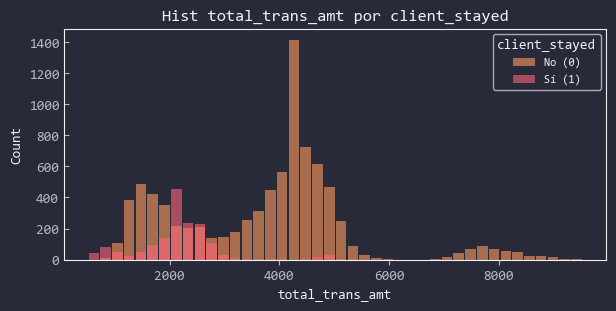

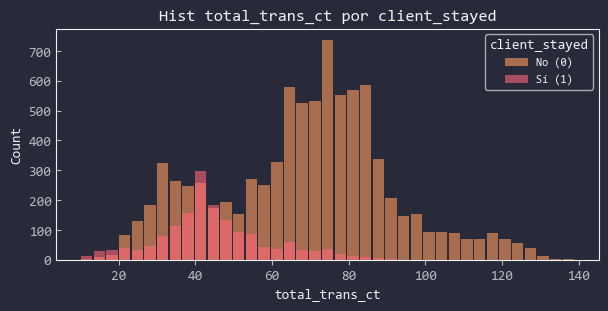

In [439]:
for column in columnas_a_tratar:
    if column != 'client_stayed': 
        plt.figure(figsize=(7, 3))
        sns.histplot(
            data=df,
            x=column,
            hue='client_stayed',
            multiple='layer',  
            # kde=True,         
            alpha=0.6,        
            shrink=0.9,
            edgecolor='none',
        )
        plt.title(f'Hist {column} por client_stayed', fontsize=12)
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Count', fontsize=10)
        plt.legend(title='client_stayed', labels=['No (0)', 'Sí (1)'], fontsize=8)
        plt.show()

In [440]:
columnas_a_tratar = ['total_trans_ct', 'total_trans_amt', 'months_on_book']

# Diccionario para guardar los resultados
resultados = {}

for columna in columnas_a_tratar:
    resultados[columna] = {
        'mean': df[columna].mean(),
        'median': df[columna].median(),
        'std': df[columna].std(),
        'mode': df[columna].mode().tolist()  # Convertir a lista por si hay múltiples modas
    }

# Convertir el diccionario a DataFrame para mejor visualización
df_resultados = pd.DataFrame(resultados).T  # Transponer para que las columnas sean las métricas
print(df_resultados)


                        mean  median          std      mode
total_trans_ct     64.853659    67.0    23.471789    [81.0]
total_trans_amt  3488.107732  3779.0  1598.919105  [4253.0]
months_on_book     35.928409    36.0     7.986416    [36.0]


In [441]:
columnas_analizar = ['total_trans_ct', 'total_trans_amt', 'months_on_book']

def generar_reporte_outliers(df, columnas):
    # Cabecera del reporte
    print("\n" + "="*92)
    print(f"{'REPORTE DE OUTLIERS - ANÁLISIS COMPLETO':^92}")
    print("="*92)
    print(f"{'Columna':<25} {'Tipo':<10} {'Outliers':>10} {'%':>8} {'L. Inferior':>15} {'L. Superior':>15}")
    print("-"*92)
    
    for col in columnas:
        # Cálculo de estadísticas
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lim_inf) | (df[col] > lim_sup)]
        n_outliers = len(outliers)
        pct_outliers = (n_outliers/len(df))*100
        
        # Formateo de números
        str_lim_inf = f"{lim_inf:,.2f}" if isinstance(lim_inf, float) else f"{int(lim_inf):,}"
        str_lim_sup = f"{lim_sup:,.2f}" if isinstance(lim_sup, float) else f"{int(lim_sup):,}"
        
        # Impresión formateada
        print(f"{col:<25} {str(df[col].dtype):<10} {n_outliers:>10,} {pct_outliers:>7.2f}% {str_lim_inf:>15} {str_lim_sup:>15}")
    
    print("="*92)
    print(f"{'Nota: Límites calculados con método IQR (Q1-1.5*IQR, Q3+1.5*IQR)':^92}")
    print("="*92)

# Generar el reporte
generar_reporte_outliers(df, columnas_analizar)


                          REPORTE DE OUTLIERS - ANÁLISIS COMPLETO                           
Columna                   Tipo         Outliers        %     L. Inferior     L. Superior
--------------------------------------------------------------------------------------------
total_trans_ct            float64             2    0.02%           -9.00          135.00
total_trans_amt           float64           220    2.17%       -1,376.50        7,915.50
months_on_book            float64           386    3.81%           17.50           53.50
              Nota: Límites calculados con método IQR (Q1-1.5*IQR, Q3+1.5*IQR)              


In [442]:
columnas_numericas = ['months_on_book','total_trans_amt','total_trans_ct']

for columna in columnas_numericas:
    # Calcular Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para atípicos
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Calcular la moda (el más frecuente)
    moda = df[columna].mode()[0]
    
    # Reemplazar atípicos con la moda
    df[columna] = np.where(
        (df[columna] < limite_inferior) | (df[columna] > limite_superior),
        moda,
        df[columna]
    )


In [443]:
"""
Q1 = df['credit_limit'].quantile(0.25)
Q3 = df['credit_limit'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 3 * IQR  # Aumentamos el límite

# Paso 2: Reemplazar por la MEDIANA (evita usar moda si es outlier)
valor_reemplazo = df['credit_limit'].median()  # Mediana es 12.5 en este caso
df['credit_limit'] = np.where(
    df['credit_limit'] > limite_superior,
    valor_reemplazo,
    df['credit_limit']
)

# Verificación
print("Valores únicos después de reemplazo:", df['credit_limit'].unique())
print("¿Quedan outliers?", any(df['credit_limit'] > limite_superior))
"""

'\nQ1 = df[\'credit_limit\'].quantile(0.25)\nQ3 = df[\'credit_limit\'].quantile(0.75)\nIQR = Q3 - Q1\nlimite_superior = Q3 + 3 * IQR  # Aumentamos el límite\n\n# Paso 2: Reemplazar por la MEDIANA (evita usar moda si es outlier)\nvalor_reemplazo = df[\'credit_limit\'].median()  # Mediana es 12.5 en este caso\ndf[\'credit_limit\'] = np.where(\n    df[\'credit_limit\'] > limite_superior,\n    valor_reemplazo,\n    df[\'credit_limit\']\n)\n\n# Verificación\nprint("Valores únicos después de reemplazo:", df[\'credit_limit\'].unique())\nprint("¿Quedan outliers?", any(df[\'credit_limit\'] > limite_superior))\n'

In [444]:

"""
columna = "customer_age"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para customer_age:", outliers.shape[0])

columna = "months_on_book"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para months_on_book:", outliers.shape[0])


columna = "credit_limit"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para credit_limit:", outliers.shape[0])

columna = "total_trans_amt"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para total_trans_amt:", outliers.shape[0])

columna = "total_trans_ct"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para total_trans_ct:", outliers.shape[0])
"""

'\ncolumna = "customer_age"\n\nQ1 = df[columna].quantile(0.25)\nQ3 = df[columna].quantile(0.75)\nIQR = Q3 - Q1\n\n\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\n\noutliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]\n\n\nprint("Número de outliers para customer_age:", outliers.shape[0])\n\ncolumna = "months_on_book"\n\nQ1 = df[columna].quantile(0.25)\nQ3 = df[columna].quantile(0.75)\nIQR = Q3 - Q1\n\n\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\n\noutliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]\n\n\nprint("Número de outliers para months_on_book:", outliers.shape[0])\n\n\ncolumna = "credit_limit"\n\nQ1 = df[columna].quantile(0.25)\nQ3 = df[columna].quantile(0.75)\nIQR = Q3 - Q1\n\n\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\n\noutliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]\n\n\nprint("Número de outliers para credit_li

In [445]:
columnas_a_tratar = ['total_trans_ct', 'total_trans_amt', 'months_on_book']

# Diccionario para guardar los resultados
resultados = {}

for columna in columnas_a_tratar:
    resultados[columna] = {
        'mean': df[columna].mean(),
        'median': df[columna].median(),
        'std': df[columna].std(),
        'mode': df[columna].mode().tolist()  # Convertir a lista por si hay múltiples modas
    }

# Convertir el diccionario a DataFrame para mejor visualización
df_resultados = pd.DataFrame(resultados).T  # Transponer para que las columnas sean las métricas
print(df_resultados)


                        mean  median          std      mode
total_trans_ct     64.842303    67.0    23.450051    [81.0]
total_trans_amt  3397.931273  3779.0  1425.842894  [4253.0]
months_on_book     35.946677    36.0     6.934324    [36.0]
